# Align and remove blanks

Adapted from Giulia Vallardi's ImageJ macro, this notebook removes any blank frames from timelapse experiments and aligns the images. 

"Fiji macro to remove over- and under-exposed images, and align the image stacks

The settings for the alignments are: 
registration by Translation > only modify XY coordinates
Shrinkage constrain activated (this model allows a better registration based on all images, not using a reference image. It is more time consuming though)
Transform matrices are saved during registration and then applied to the other channels during transformation."

In [11]:
import os
import glob
import enum
import numpy as np
from pystackreg import StackReg
from skimage import io
from tqdm import tqdm
from daskoctopus import DaskOctopusLiteLoader

In [9]:
# define channels (in order)
@enum.unique
class channels(enum.Enum):
    #bf = 0 
    gfp = 1
    rfp = 2
    #irfp = 3

### Use the dask octopus loader to load files into virtual stacks from raw unorganised list of files (aligned folder name below is wrong)

In [3]:
### USING DASK OCTO
GV = "MK0003"
POS = "PosX"
PATH = f"/home/nathan/data/kraken/commitment/test/{GV}/{POS}/{POS}_aligned"
octopus = DaskOctopusLiteLoader(PATH)#, crop=(1200, 1600))

Using cropping: None


In [4]:
gfp = octopus["GFP"]
rfp = octopus["RFP"]

#### need to load the actual image in order for the stack reg to work

In [5]:
reference_image = gfp.compute()

In [6]:
reference_image.shape

(1200, 1352, 1688)

In [14]:
import timeit

# currently fails at step 4 (transforming an image) for a standard sized timelapse

In [ ]:
start_time = timeit.default_timer()


# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 
print(1)
# register each frame to the previous as transformation matrices
t_mats = sr.register_stack(reference_image, reference = 'previous').astype(np.uint8)
print(2)
# save out transformatrion matrices
### format for channel choice
np.save(os.path.join(PATH, 'rfp_dask_transformation_matrices.npy'), t_mats)
print(3)
# transform original stack
transformed_image = sr.transform_stack(reference_image).astype(np.uint8)
print(4)
# save out original transformed stack 
### new directory
io.imsave(os.path.join(PATH,'trans_rfp.tif'), transformed_image)
print(5)
# load other images and transform them
### for channel in other channels
### if not reference channel
image = rfp.compute()#io.imread(os.path.join(data_dir,'Pos1_stacks/gfp_short.tif'))
print(7)
transformed_image = sr.transform_stack(image, tmats=t_mats).astype(np.uint8)
print(8)
io.imsave(os.path.join(PATH,'trans_gfp.tif'), transformed_image)


elapsed = timeit.default_timer() - start_time
print(elapsed)

1
2
3


In [ ]:
### define pos and expt 
expt = 'MK0003'
pos = 'Pos1'
root_dir = '/home/nathan/data/kraken/commitment/test/'
data_dir = os.path.join(root_dir, expt, pos)

### move raw files into raw files directory and create aligned dir
raw_data_dir = os.path.join(data_dir, f'{pos}_raw')
os.mkdir(raw_data_dir)
raw_files = glob.glob(os.path.join(data_dir, '*.tif'))
for filename in raw_files:
    os.rename(filename, filename.replace(f'{pos}', f'{pos}/{pos}_raw'))
os.mkdir(os.path.join(data_dir, f'{pos}_aligned'))

### organise into dask stacks using dask octopus loader
octopus = DaskOctopusLiteLoader(raw_data_dir)#, crop=(1200, 1600))
gfp = octopus["GFP"]
rfp = octopus["RFP"]
irfp = octopus["IRFP"]
bf = octopus["BRIGHTFIELD"]

### load actual images
if reference_channel = 
reference_image = gfp.compute() if reference_channel == 'gfp' else rfp.compute()


# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 
print(1)
# register each frame to the previous as transformation matrices
t_mats = sr.register_stack(reference_image, reference = 'previous').astype(np.uint8)
print(2)
# save out transformatrion matrices
### format for channel choice
np.save(os.path.join(PATH, 'rfp_dask_transformation_matrices.npy'), t_mats)



In [41]:
### USING SKIMAGE.IO 

expt = 'MK0003'
pos = 'Pos1'

# set root dir and data dir so can be iterable 
root_dir = '/home/nathan/data/kraken/commitment/test/'
data_dir = os.path.join(root_dir, expt, pos)
### change this line to be more versatile for non_stacks as files are saved as single images originally -- use octo lite loader
### also change for channel choice
reference_image = io.imread(os.path.join(data_dir,'Pos1_stacks/rfp_short.tif')) # 3 dimensions : frames x width x height

# create operator using transformation type (translation)
sr = StackReg(StackReg.TRANSLATION) 

# register each frame to the previous as transformation matrices
t_mats = sr.register_stack(reference_image, reference = 'previous').astype(np.uint8)

# save out transformatrion matrices
### format for channel choice
np.save(os.path.join(data_dir, 'rfp_transformation_matrices.npy'), t_mats)

# transform original stack
transformed_image = sr.transform_stack(reference_image).astype(np.uint8)

# save out original transformed stack 
### new directory
io.imsave('trans_rfp.tif', transformed_image)

# load other images and transform them
### for channel in other channels
### if not reference channel
image = io.imread(os.path.join(data_dir,'Pos1_stacks/gfp_short.tif'))
transformed_image = sr.transform_stack(image, tmats=t_mats).astype(np.uint8)
io.imsave('trans_gfp.tif', transformed_image)


<ipython-input-41-87bf055a6488>:26: UserWarning: trans_rfp.tif is a low contrast image
  io.imsave('trans_rfp.tif', transformed_image)


In [37]:
type(reference_image[0,0,0])

numpy.uint8

In [39]:
type(t_mats[0,0,0])

numpy.float64

In [40]:
type(transformed_image[0,0,0])

numpy.float64

In [17]:


img0 = io.imread('/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_stacks/rfp_short.tif') # 3 dimensions : frames x width x height
print(1)
img1 = io.imread('/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_stacks/gfp_short.tif') # same shape as img0
print(2)

# both stacks must have the same shape
assert img0.shape == img1.shape
print(3)

# create operator using transformation
sr = StackReg(StackReg.RIGID_BODY) 
print(4, 'long step')
# register each frame to the previous (already registered) one
# this is what the original StackReg ImageJ plugin uses
tmats = sr.register_stack(img0, reference='previous')
print(4.5)
out = sr.transform_stack(img1)
print(5)

# tmats contains the transformation matrices -> they can be saved
# and loaded at another time
import numpy as np
np.save('/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_stacks/transformation_matrices.npy', tmats)
print(6)

tmats_loaded = np.load('/home/nathan/data/kraken/commitment/test/MK0003/Pos1/Pos1_stacks/transformation_matrices.npy')
print(7)

# make sure you use the correct transformation here!
sr = StackReg(StackReg.RIGID_BODY)
print(8)

# transform stack using the tmats loaded from file
sr.transform_stack(img1, tmats=tmats_loaded)
print(9)

# with the transformation matrices at hand you can also
# use the transformation algorithms from other packages:
from skimage import transform as tf

out = np.zeros(img0.shape).astype(float)
print(10)

for i in tqdm(range(tmats.shape[0])):
    tform = tf.AffineTransform(matrix=tmats[i, :, :])
    out[i, :, :] = tf.warp(img1[i, :, :], tform)

1
2
3
4 long step
4.5
5
6
7
8
9
10


100%|██████████| 10/10 [00:00<00:00, 21.84it/s]


In [18]:
type(sr.transform_stack(img1, tmats=tmats_loaded))

numpy.ndarray

In [8]:
import matplotlib.pyplot as plt

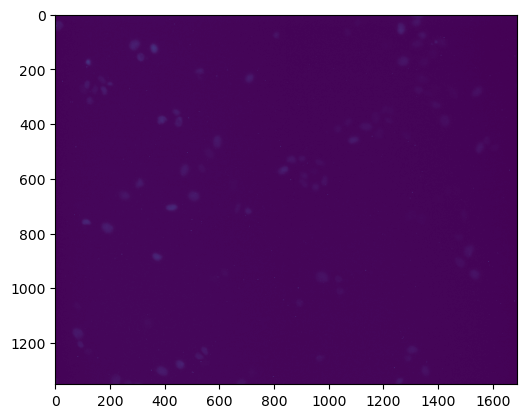

In [14]:
plt.imshow(img0[i])
plt.show()

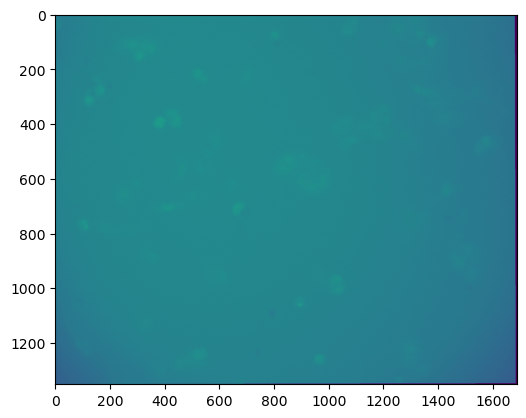

In [15]:
plt.imshow(out[i])
plt.show()

In [10]:
# ### Macro code from Fiji

# macro "Remove blanks+align GFP" {

# // Batch mode allows fiji to work with images but not have them actually open - saves time and memory
# setBatchMode(true);

# // Choose the PosX you wish to align, get info on which files are present, and the name of the folder
# dir = getDirectory("Choose a Directory");
# lista = getFileList(dir);
# name = File.getName(dir);



initial_img_dir = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}'
#file_list = os.listdir(initial_img_dir)
### or for full list of file paths
file_list = glob.glob(os.path.join(initial_img_dir, '*.tif'))

# // Name and create the 'raw' and 'blanks_removed' folders.
# rawName=name+"_raw";
# rawDir=dir+rawName;

# make directories to organise raw and blanks into
os.mkdir(os.path.join(initial_img_dir, f'{pos}_raw'))
os.mkdir(os.path.join(initial_img_dir, f'{pos}_blanks'))

# File.makeDirectory(rawDir);

# this creates seperate directories for each channel of removed blanks
## necessary????
# Pname = name + "_blanks_removed";
# Ch0=Pname+"_Ch0";
# Ch1=Pname+"_Ch1";
# Ch2=Pname+"_Ch2";
# Ch0folder=dir+Ch0;
# File.makeDirectory(Ch0folder);
# Ch1folder=dir+Ch1;
# File.makeDirectory(Ch1folder);
# Ch2folder=dir+Ch2;
# File.makeDirectory(Ch2folder);


# // Define the image prefix for each channel
# Ch0prefix = "img_channel000";
# Ch1prefix = "img_channel001";
# Ch2prefix = "img_channel002";
# //Number of images
# numberSlice=lista.length;
# // import all the images in the PosX folder
# run("Image Sequence...","open=&dir number="+numberSlice+" starting=1 increment=1 scale=100 file=channel sort");
# // Select the stack
# imageID= getImageID();
# if (isOpen (imageID)) {
# selectImage (imageID);
# }
# // Define the number of channels and timepoints of the experiment
# nChannels=3;
# nFrames = nSlices / nChannels;
# // Create a hyperstack
# run("Stack to Hyperstack...", "order=xytcz channels=" + nChannels + " slices=1 frames=" + nFrames + " display=Grayscale");
# // Run the Measurestack function (described below)

# Measurestack in imagej is employed to measure the mean value of each image
# iterate over each channel and all frames in channel to measure mean value
#exclude if <2 or >200



# Measurestack(imageID);
# function Measurestack(imageID) {
# 	setOption("Stack position", true);

# 	// For each slice (aka frame) measure the mean image value, and get info regarding frame and channel
# 	for (slice=1; slice<=nSlices; slice++) {
# 		setSlice(slice);
# 		run("Measure");
# 		r=getResult("Mean");
# 		frame=getResult("Frame");
# 		channel=getResult("Ch");

# 			// Depending on the mean value, either do nothing or move the image if it's not suitable for alignment (by calling the MoveBoOX function)
# 			if (r<=2) {
# 			print("Mean: " + r + ". " + "frame: " + frame + " Ch: " + channel + " is a blank");
# 			MoveBoOX(imageID);
# 			}
# 			else if (r>=200) {
# 			print("Mean: " + r + ". " + "frame: " + frame + " Ch: " + channel + " is overexposed");
# 			MoveBoOX(imageID);
# 			}
# 			else if (r>2 && r<200) {
# 			print("Mean: " + r + ". " + "frame: " + frame + " Ch: " + channel);
# 			}
# 	}
# }

# // MoveBoOX function will move all channels related to an over or underexposed frame to the _raw folder
# function MoveBoOX(imageID) {

# 	// frame is frame -1 because fiji starts from 1, but files start from 0
# 	frameN=getValue("Frame")-1;
# 	print(frameN);
# 	end=""+frameN+"_z000.tif";
# 	print(end);
# 	// For any image in the list that has the specified frame, move it to _raw folder
# 	for (i = 0; i < lista.length; i++) {
# 		if (endsWith(lista[i], end)) {
# 		File.rename(dir+lista[i], rawDir+File.separator+lista[i]);
# 		}
# 	}
# }

# // Any image that was ok for mean value, move it to a _blanks_removed folder, according to the specific channel
# for (i = 0; i < lista.length; i++) {
# 		if (startsWith(lista[i], Ch0prefix)) {
# 		File.rename(dir+lista[i], Ch0folder+File.separator+lista[i]);
# 		}
# 		if (startsWith(lista[i], Ch1prefix)) {
# 		File.rename(dir+lista[i], Ch1folder+File.separator+lista[i]);
# 		}
# 		if (startsWith(lista[i], Ch2prefix)) {
# 		File.rename(dir+lista[i], Ch2folder+File.separator+lista[i]);
# 		}
# }

# print("");
# print("Blanks Removed");
# print("");
# run("Clear Results");
# run("Close All");

# // Run the transform function
# Transform (imageID);

# function Transform (imageID) {

# 	// Create folders for _aligned and _transforms files
# 	name=File.getName(dir);
# 	outputName = name+"_aligned";
# 	output = dir+outputName;
# 	File.makeDirectory(output);
# 	Transformsname=name+"_transforms";
# 	Transforms=dir+Transformsname;
# 	File.makeDirectory(Transforms);

# 	// Run the register virtual stack function on ch1 with the specified settings, save the transform matrices
# 	print("Running Register Virtual Stack Slices on Ch1...");
# 	run("Register Virtual Stack Slices", "source=["+Ch1folder+"] output=["+output+"] feature=Translation registration=[Translation          -- no deformation                      ] save shrinkage");
# 	print("Ch1 registered and trasforms stored");
# 	Ch1image=getTitle();
# 	close(Ch1image);

# 	// Run the transofrm virtual stack function on ch0 with the correct transformation matrices
# 	print("Running Transform Virtual Stack Slices on Ch0...");
# 	run("Transform Virtual Stack Slices", "source=["+Ch0folder+"] output=["+output+"] transforms=["+Transforms+"]");
# 	print("Ch0 transformed");
# 	Ch0image=getTitle();
# 	close(Ch0image);

# 	// Run the transofrm virtual stack function on ch2 with the correct transformation matrices
# 	print("Running Transform Virtual Stack Slices on Ch2...");
# 	run("Transform Virtual Stack Slices", "source=["+Ch2folder+"] output=["+output+"] transforms=["+Transforms+"]");
# 	print("Ch2 transformed");
# 	Ch2image=getTitle();
# 	close(Ch2image);

# 	print("Finished");

# 	// Save the log data as a log file
# 	selectWindow("Log");
# 	LogName="Log_blanks_e_register";
# 	saveAs("text", dir+LogName);
# }

# // Move all original files in the _blanks_removed folders to the raw folder.
# print("Moving files to raw folder...");

# listCh0=getFileList(Ch0folder);
# for (i = 0; i < listCh0.length; i++) {
# 	File.rename(Ch0folder+File.separator+listCh0[i], rawDir+File.separator+listCh0[i]);
# 	}

# listCh1=getFileList(Ch1folder);
# for (j = 0; j < listCh1.length; j++) {
# 	File.rename(Ch1folder+File.separator+listCh1[j], rawDir+File.separator+listCh1[j]);
# 	}

# listCh2=getFileList(Ch2folder);
# for (k = 0; k < listCh2.length; k++) {
# 	File.rename(Ch2folder+File.separator+listCh2[k], rawDir+File.separator+listCh2[k]);
# 	}

# // Delete the empty folders
# print("deleting intermediate folders...");
# File.delete(Ch0folder);
# File.delete(Ch1folder);
# File.delete(Ch2folder);

# // Clear the log window
# print("\\Clear");
# }